In [27]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## Create SwanGraph

In [28]:
annot = '../../refs/gencode_v29_sirv4_ercc.gtf'
ab = '../talon/human_talon_abundance_filtered.tsv'
gtf = '../talon/human_known_nic_nnc_talon.gtf'

In [29]:
sg = swan.SwanGraph()

In [31]:
sg.add_annotation(annot)
sg.add_transcriptome(gtf)
sg.add_abundance(ab)

In [6]:
sg.save_graph('swan')

Saving graph as swan.p


## Get metadata

In [28]:
meta = sg.adata.obs.copy(deep=True)
meta.reset_index(inplace=True, drop=True)
meta['biosample'] = meta.dataset.str.rsplit('_', n=2, expand=True)[0]

tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]

meta = meta.merge(tissue_df, how='left', on='biosample')
meta.head()
meta['classification'] = 'tissue'
meta.loc[meta.tissue.isnull(), 'classification'] = 'cell_line'

meta.loc[meta.tissue.isnull(), 'tissue'] = meta.loc[meta.tissue.isnull(), 'biosample']
meta.drop('biosample', axis=1, inplace=True)
meta.rename({'tissue': 'biosample'}, axis=1, inplace=True)

print('Found {} total samples'.format(len(meta.biosample.unique().tolist())))

Found 31 total samples


In [29]:
meta.head()

,dataset,biosample,classification
0,gm12878_1_1,gm12878,cell_line
1,gm12878_1_2,gm12878,cell_line
2,gm12878_1_3,gm12878,cell_line
3,gm12878_1_4,gm12878,cell_line
4,gm12878_3_1,gm12878,cell_line


In [30]:
meta.to_csv('swan_metadata.tsv', sep='\t', index=False)

## Add metadata

In [10]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [11]:
meta = 'swan_metadata.tsv'
sg.add_metadata('swan_metadata.tsv')

# colors
c_dict, order = get_biosample_colors()
sg.set_metadata_colors('biosample', c_dict)

sg.save_graph('swan')

Saving graph as swan.p


### How many isoforms use each of the different exons in Elastin?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples
Found 139 isoforms for ELN


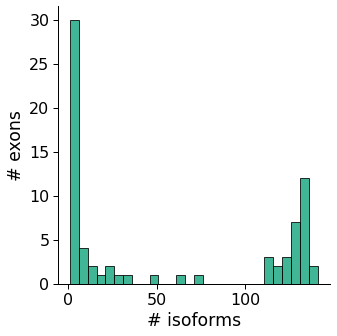

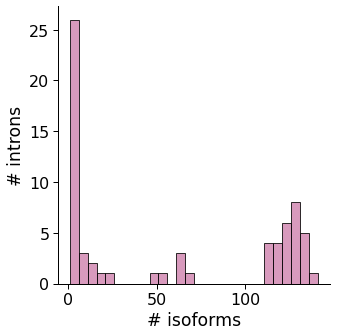

In [2]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
plot_exon_hist(sg, df, 'ELN',
               min_tpm=1,
               gene_subset='polya',
               sample='all', 
               groupby='sample', 
               nov=['Known', 'NIC', 'NNC'], 
               opref='figures/human')

In [47]:
# get elastin isoforms
eln_df = sg.t_df.loc[sg.t_df.gname == 'ELN']
eln_df = swan.pivot_path_list(eln_df, 'path')
eln_df = eln_df.merge(sg.edge_df, how='left', left_on='edge_id', right_index=True, suffixes=(None, '_dupe'))
eln_df = eln_df.merge(sg.t_df[['tname']], how='left', left_index=True, right_index=True)
eln_df.drop('edge_id_dupe', axis=1, inplace=True)

# reformat
eln_df = eln_df[['edge_id', 'edge_type']]
eln_df.reset_index(inplace=True)


In [48]:
# get tids of expressed isoforms of elastin
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
df = get_det_table(df, 
                   how='iso', 
                   min_tpm=1, 
                   gene_subset='polya',
                   groupby='all',
                   nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


In [49]:
det_tids = df.columns.tolist()
det_tids = list(set(det_tids)&set(eln_df.tid.tolist()))
print(len(det_tids))

139


In [50]:
# limit to only detected isoforms
eln_df = eln_df.loc[eln_df.tid.isin(det_tids)]

In [51]:
# groupby and count the number of isoforms that use each edge
eln_df = eln_df.groupby(['edge_id', 'edge_type']).count().reset_index()
eln_df.rename({'tid':'n_isos'}, axis=1, inplace=True)
eln_df

,edge_id,edge_type,n_isos
0,360310,exon,5
1,360311,intron,137
2,360312,exon,137
3,360313,intron,118
4,360314,exon,119
...,...,...,...
135,964013,intron,1
136,964014,intron,2
137,964015,exon,2
138,964016,intron,2


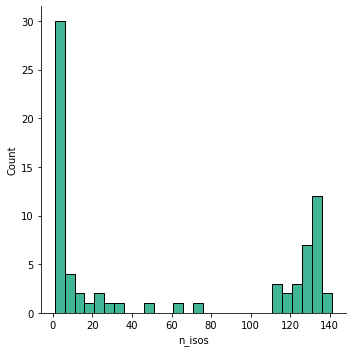

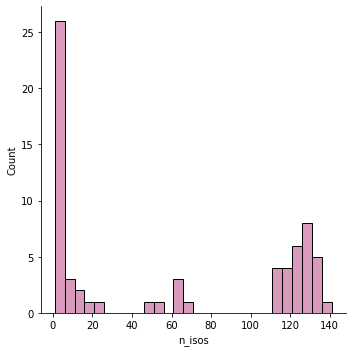

In [57]:
c_dict = {'intron': '#CC79A7', 'exon': '#009E73'}
for e_type in eln_df.edge_type.unique():
    df = eln_df.loc[eln_df.edge_type == e_type]
    sns.displot(data=df, x='n_isos', kind='hist', color=c_dict[e_type], binwidth=5)

In [4]:
len(eln_df)

158

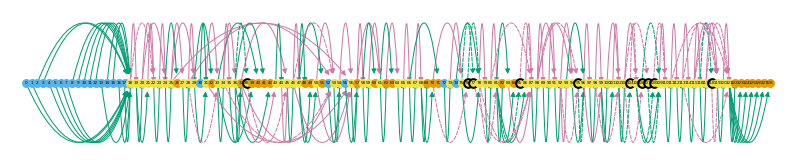

In [13]:
sg.plot_graph('ELN', indicate_novel=True)

In [16]:
eln_df.head()

,edge_id_x,edge_id_y
tid,,
ENCODEHT000578981,360388,360388
ENCODEHT000578981,360388,360311
ENCODEHT000578981,360388,360312
ENCODEHT000578981,360388,360313
ENCODEHT000578981,360388,360314


In [ ]:
eln_df.head()

In [14]:
sg.edge_df.head()

,v1,v2,strand,edge_type,edge_id,annotation
edge_id,,,,,,
981370,1,0,-,exon,981370,False
981369,2,1,-,intron,981369,False
981368,3,2,-,exon,981368,False
981367,4,3,-,intron,981367,False
981377,5,2,-,exon,981377,False


In [32]:
sg.plot_graph('DES', indicate_novel=True, prefix='figures/des')

Saving summary graph for ENSG00000175084.11 as figures/des_novel_ENSG00000175084.11_summary.png


In [34]:
sg.plot_transcript_path('ENST00000373960.3', indicate_novel=True, prefix='figures/des')

Saving transcript path graph for ENST00000373960.3 as figures/des_novel_ENST00000373960.3_path.png


In [35]:
sg.plot_transcript_path('ENCODEHT002835059', indicate_novel=True, prefix='figures/des')

Saving transcript path graph for ENCODEHT002835059 as figures/des_novel_ENCODEHT002835059_path.png


## Reports

In [24]:
def make_biosamp_reports(gene):
    def make_reports(gene, c):
        opref = 'figures/{}_{}'.format(gene.lower(), c)
        sg.gen_report(gene,
                  prefix=opref,
                  layer='pi',
                  cmap='magma',
                  novelty=True,
                  groupby='biosample',
                  transcript_name=True,
                  metadata_cols=['biosample'],
                  datasets={'classification': c},
                  browser=True)

        sg.gen_report(gene,
                      prefix=opref,
                      layer='tpm',
                      cmap='viridis',
                      novelty=True,
                      groupby='biosample',
                      transcript_name=True,
                      metadata_cols=['biosample'],
                      indicate_novel=True,
                      datasets={'classification': c})
        
    c = 'tissue'
    make_reports(gene, c)
    c = 'cell_line'
    make_reports(gene, c)    

In [26]:
make_biosamp_reports('DES')


Plotting transcripts for ENSG00000175084.11
Saving transcript path graph for ENST00000373960.3 as figures/des_tissue_browser_ENST00000373960.3_path.png
Saving transcript path graph for ENST00000483395.1 as figures/des_tissue_browser_ENST00000483395.1_path.png
Saving transcript path graph for ENCODEHT002835059 as figures/des_tissue_browser_ENCODEHT002835059_path.png
Saving transcript path graph for ENCODEHT002835660 as figures/des_tissue_browser_ENCODEHT002835660_path.png
Saving transcript path graph for ENCODEHT002836491 as figures/des_tissue_browser_ENCODEHT002836491_path.png
Saving transcript path graph for ENCODEHT001014840 as figures/des_tissue_browser_ENCODEHT001014840_path.png
Saving transcript path graph for ENCODEHT002339506 as figures/des_tissue_browser_ENCODEHT002339506_path.png
Saving transcript path graph for ENCODEHT002836352 as figures/des_tissue_browser_ENCODEHT002836352_path.png
Saving transcript path graph for ENCODEHT002836504 as figures/des_tissue_browser_ENCODEHT00

In [25]:
make_biosamp_reports('MYH7')


Plotting transcripts for ENSG00000092054.12
Saving transcript path graph for ENST00000355349.3 as figures/myh7_tissue_browser_ENST00000355349.3_path.png
Saving transcript path graph for ENCODEHT002509576 as figures/myh7_tissue_browser_ENCODEHT002509576_path.png
Saving transcript path graph for ENCODEHT002511948 as figures/myh7_tissue_browser_ENCODEHT002511948_path.png
Saving transcript path graph for ENCODEHT002511093 as figures/myh7_tissue_browser_ENCODEHT002511093_path.png
Saving transcript path graph for ENCODEHT002509562 as figures/myh7_tissue_browser_ENCODEHT002509562_path.png
Saving transcript path graph for ENCODEHT002509573 as figures/myh7_tissue_browser_ENCODEHT002509573_path.png
Saving transcript path graph for ENCODEHT002510879 as figures/myh7_tissue_browser_ENCODEHT002510879_path.png
Saving transcript path graph for ENCODEHT002509778 as figures/myh7_tissue_browser_ENCODEHT002509778_path.png
Saving transcript path graph for ENCODEHT002511483 as figures/myh7_tissue_browser_E

In [ ]:
# elastin report
sg.gen_report('MYH7',
              prefix='figures/myh7_tissue',
              layer='pi',
              cmap='magma',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'tissue'},
              browser=True)

sg.gen_report('MYH7',
              prefix='figures/myh7_tissue',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'tissue'})

In [9]:
# elastin report
sg.gen_report('ELN',
              prefix='figures/eln_tissue',
              layer='pi',
              cmap='magma',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'tissue'},
              browser=True)

sg.gen_report('ELN',
              prefix='figures/eln_tissue',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'tissue'})


Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENST00000445912.5 as figures/eln_tissue_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_tissue_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT001481409 as figures/eln_tissue_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_tissue_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_tissue_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_tissue_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_tissue_browser_ENCODEHT002323596_path.png
Saving transcript path graph for ENST00000357036.9 as figures/eln_tissue_browser_ENST00000357036.9_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_tissue_browser_ENST0000

In [8]:
# elastin report
sg.gen_report('ELN',
              prefix='figures/eln',
              layer='pi',
              cmap='magma',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'cell_line'},
              browser=True)

sg.gen_report('ELN',
              prefix='figures/eln',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'cell_line'})


Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT001481404 as figures/eln_browser_ENCODEHT001481404_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_browser_ENCODEHT002323596_path.png
Saving transcript path graph for ENCODEHT002

In [11]:
sg.tss_adata.var.head()

,gid,gname,vertex_id,tss_name
tss_id,,,,
ENCODEHG000058784_1,ENCODEHG000058784,ENCODEHG000058784,39,ENCODEHG000058784_1
ENCODEHG000058784_2,ENCODEHG000058784,ENCODEHG000058784,42,ENCODEHG000058784_2
ENCODEHG000058837_1,ENCODEHG000058837,ENCODEHG000058837,10,ENCODEHG000058837_1
ENCODEHG000058837_2,ENCODEHG000058837,ENCODEHG000058837,14,ENCODEHG000058837_2
ENCODEHG000058844_1,ENCODEHG000058844,ENCODEHG000058844,43,ENCODEHG000058844_1


In [6]:
sg.gen_report('DES',
              prefix='figures/des',
              layer='pi',
              cmap='magma',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'tissue'},
              browser=True)


Plotting transcripts for ENSG00000175084.11
Saving transcript path graph for ENST00000373960.3 as figures/des_browser_ENST00000373960.3_path.png
Saving transcript path graph for ENST00000483395.1 as figures/des_browser_ENST00000483395.1_path.png
Saving transcript path graph for ENCODEHT002835059 as figures/des_browser_ENCODEHT002835059_path.png
Saving transcript path graph for ENCODEHT002835660 as figures/des_browser_ENCODEHT002835660_path.png
Saving transcript path graph for ENCODEHT002836491 as figures/des_browser_ENCODEHT002836491_path.png
Saving transcript path graph for ENCODEHT001014840 as figures/des_browser_ENCODEHT001014840_path.png
Saving transcript path graph for ENCODEHT002339506 as figures/des_browser_ENCODEHT002339506_path.png
Saving transcript path graph for ENCODEHT002836352 as figures/des_browser_ENCODEHT002836352_path.png
Saving transcript path graph for ENCODEHT002836504 as figures/des_browser_ENCODEHT002836504_path.png
Saving transcript path graph for ENCODEHT00283

In [7]:
sg.gen_report('DES',
              prefix='figures/des',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'tissue'})


Plotting transcripts for ENSG00000175084.11
Saving transcript path graph for ENST00000373960.3 as figures/des_ENST00000373960.3_path.png
Saving transcript path graph for ENST00000483395.1 as figures/des_ENST00000483395.1_path.png
Saving transcript path graph for ENCODEHT002835059 as figures/des_ENCODEHT002835059_path.png
Saving transcript path graph for ENCODEHT002835660 as figures/des_ENCODEHT002835660_path.png
Saving transcript path graph for ENCODEHT002836491 as figures/des_ENCODEHT002836491_path.png
Saving transcript path graph for ENCODEHT001014840 as figures/des_ENCODEHT001014840_path.png
Saving transcript path graph for ENCODEHT002339506 as figures/des_ENCODEHT002339506_path.png
Saving transcript path graph for ENCODEHT002836352 as figures/des_ENCODEHT002836352_path.png
Saving transcript path graph for ENCODEHT002836504 as figures/des_ENCODEHT002836504_path.png
Saving transcript path graph for ENCODEHT002835519 as figures/des_ENCODEHT002835519_path.png
Saving transcript path gr

In [15]:
# where are the TSSs for Elastin?
df = sg.get_tss_abundance(kind='tpm')
df = df.loc[df.gname == 'ELN']

In [24]:
df

,tss_id,gid,gname,vertex_id,tss_name,chrom,coord,gm12878_1_1,gm12878_1_2,gm12878_1_3,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
6500,ENSG00000049540.16_1,ENSG00000049540.16,ELN,821937,ELN_1,chr7,74027789,0.0,0.0,0.0,...,11.608784,47.126377,48.933109,39.749577,40.375385,0.0,7.196885,20.005281,13.122725,90.904961
6501,ENSG00000049540.16_2,ENSG00000049540.16,ELN,821938,ELN_2,chr7,74028101,0.0,0.0,0.0,...,2.902196,19.938084,26.256790,15.899831,12.288161,0.0,4.797924,0.000000,8.201703,28.407799
6502,ENSG00000049540.16_3,ENSG00000049540.16,ELN,821939,ELN_3,chr7,74028106,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,1.987479,3.510903,0.0,2.398962,2.000528,1.640341,7.954184
6503,ENSG00000049540.16_4,ENSG00000049540.16,ELN,821940,ELN_4,chr7,74028109,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6504,ENSG00000049540.16_5,ENSG00000049540.16,ELN,821941,ELN_5,chr7,74028114,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,2.000528,0.000000,3.408936
6505,ENSG00000049540.16_6,ENSG00000049540.16,ELN,821942,ELN_6,chr7,74028124,0.0,0.0,0.0,...,0.000000,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6506,ENSG00000049540.16_7,ENSG00000049540.16,ELN,821943,ELN_7,chr7,74028126,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6507,ENSG00000049540.16_8,ENSG00000049540.16,ELN,821944,ELN_8,chr7,74028129,0.0,0.0,0.0,...,0.000000,0.000000,4.177217,1.987479,0.000000,0.0,0.000000,0.000000,2.460511,0.000000
6508,ENSG00000049540.16_9,ENSG00000049540.16,ELN,821945,ELN_9,chr7,74028141,0.0,0.0,0.0,...,0.000000,1.812553,0.596745,0.000000,1.755452,0.0,0.000000,0.000000,1.640341,2.272624
6509,ENSG00000049540.16_10,ENSG00000049540.16,ELN,821946,ELN_10,chr7,74028144,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [19]:
df.coord.max()-df.coord.min()

25062

In [21]:
df.coord.max()

74052851

In [22]:
df.coord.min()

74027789

In [31]:
df.head()

,tss_id,gid,gname,vertex_id,tss_name,chrom,coord,gm12878_1_1,gm12878_1_2,gm12878_1_3,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
6500,ENSG00000049540.16_1,ENSG00000049540.16,ELN,821937,ELN_1,chr7,74027789,0.0,0.0,0.0,...,11.608784,47.126377,48.933109,39.749577,40.375385,0.0,7.196885,20.005281,13.122725,90.904961
6501,ENSG00000049540.16_2,ENSG00000049540.16,ELN,821938,ELN_2,chr7,74028101,0.0,0.0,0.0,...,2.902196,19.938084,26.256790,15.899831,12.288161,0.0,4.797924,0.000000,8.201703,28.407799
6502,ENSG00000049540.16_3,ENSG00000049540.16,ELN,821939,ELN_3,chr7,74028106,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,1.987479,3.510903,0.0,2.398962,2.000528,1.640341,7.954184
6503,ENSG00000049540.16_4,ENSG00000049540.16,ELN,821940,ELN_4,chr7,74028109,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6504,ENSG00000049540.16_5,ENSG00000049540.16,ELN,821941,ELN_5,chr7,74028114,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,2.000528,0.000000,3.408936


In [26]:
tids = ['ENCODEHT001481409', 'ELN-209']

sg.t_df.loc[sg.t_df.tname.isin(tids), ['tname', 'loc_path']]

,tname,loc_path
tid,,
ENCODEHT001481409,ENCODEHT001481409,"[821951, 821955, 821956, 821957, 821959, 82196..."
ENST00000380576.9,ELN-209,"[821952, 821955, 821956, 821957, 821959, 82196..."


In [27]:
beep = sg.t_df.loc[sg.t_df.gname == 'ELN']

In [33]:
beep['tss'] = beep.apply(lambda x: x.loc_path[0], axis=1)
beep = beep.merge(df[['vertex_id', 'coord']], how='left', left_on='tss', right_on='vertex_id')

In [36]:
beep.loc[beep.tss == 822009]

,tname,gid,gname,path,tid,loc_path,annotation,novelty,tss,vertex_id,coord
147,ELN-224,ENSG00000049540.16,ELN,"[360442, 360443, 360344, 360345, 360346, 36034...",ENST00000466878.5,"[822009, 822010, 822012, 822015, 822016, 82201...",True,Known,822009,822009,74052294


In [43]:
df.head()

,tss_id,gid,gname,vertex_id,tss_name,chrom,coord,gm12878_1_1,gm12878_1_2,gm12878_1_3,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
6500,ENSG00000049540.16_1,ENSG00000049540.16,ELN,821937,ELN_1,chr7,74027789,0.0,0.0,0.0,...,11.608784,47.126377,48.933109,39.749577,40.375385,0.0,7.196885,20.005281,13.122725,90.904961
6501,ENSG00000049540.16_2,ENSG00000049540.16,ELN,821938,ELN_2,chr7,74028101,0.0,0.0,0.0,...,2.902196,19.938084,26.256790,15.899831,12.288161,0.0,4.797924,0.000000,8.201703,28.407799
6502,ENSG00000049540.16_3,ENSG00000049540.16,ELN,821939,ELN_3,chr7,74028106,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,1.987479,3.510903,0.0,2.398962,2.000528,1.640341,7.954184
6503,ENSG00000049540.16_4,ENSG00000049540.16,ELN,821940,ELN_4,chr7,74028109,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6504,ENSG00000049540.16_5,ENSG00000049540.16,ELN,821941,ELN_5,chr7,74028114,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,2.000528,0.000000,3.408936


In [48]:
# are the isoforms with the super far away tsss even expresed?
far_tss = [822009, 822011, 821967, 821992, 821989]
for tss in far_tss:
    print(df.loc[df.vertex_id == tss, sg.datasets].sum(axis=1))

6521    0.0
dtype: float32
6522    0.0
dtype: float32
6518    0.0
dtype: float32
6520    7.299387
dtype: float32
6519    0.0
dtype: float32


In [47]:
df.sort_values(by='coord')

,tss_id,gid,gname,vertex_id,tss_name,chrom,coord,gm12878_1_1,gm12878_1_2,gm12878_1_3,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
6500,ENSG00000049540.16_1,ENSG00000049540.16,ELN,821937,ELN_1,chr7,74027789,0.0,0.0,0.0,...,11.608784,47.126377,48.933109,39.749577,40.375385,0.0,7.196885,20.005281,13.122725,90.904961
6501,ENSG00000049540.16_2,ENSG00000049540.16,ELN,821938,ELN_2,chr7,74028101,0.0,0.0,0.0,...,2.902196,19.938084,26.256790,15.899831,12.288161,0.0,4.797924,0.000000,8.201703,28.407799
6502,ENSG00000049540.16_3,ENSG00000049540.16,ELN,821939,ELN_3,chr7,74028106,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,1.987479,3.510903,0.0,2.398962,2.000528,1.640341,7.954184
6503,ENSG00000049540.16_4,ENSG00000049540.16,ELN,821940,ELN_4,chr7,74028109,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6504,ENSG00000049540.16_5,ENSG00000049540.16,ELN,821941,ELN_5,chr7,74028114,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,2.000528,0.000000,3.408936
6505,ENSG00000049540.16_6,ENSG00000049540.16,ELN,821942,ELN_6,chr7,74028124,0.0,0.0,0.0,...,0.000000,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6506,ENSG00000049540.16_7,ENSG00000049540.16,ELN,821943,ELN_7,chr7,74028126,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6507,ENSG00000049540.16_8,ENSG00000049540.16,ELN,821944,ELN_8,chr7,74028129,0.0,0.0,0.0,...,0.000000,0.000000,4.177217,1.987479,0.000000,0.0,0.000000,0.000000,2.460511,0.000000
6508,ENSG00000049540.16_9,ENSG00000049540.16,ELN,821945,ELN_9,chr7,74028141,0.0,0.0,0.0,...,0.000000,1.812553,0.596745,0.000000,1.755452,0.0,0.000000,0.000000,1.640341,2.272624
6509,ENSG00000049540.16_10,ENSG00000049540.16,ELN,821946,ELN_10,chr7,74028144,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [49]:
74027789-74028188

-399